In [22]:
include("..\\Code_jail\\Master_func.jl")

int_err_plot (generic function with 2 methods)

# Quadrature
## Trapezoidal
Say we have an equidistant grid $x_i$, the trapezoidal quadrature rule is then given by 
$$
    \int_a^bf(x)\mathrm{d}x= \frac{Δx}{2}\left(f(x_0)+f(x_N)\right)+Δx\sum_{i=1}^{N-1}f(x_i)
$$
Convergence order: $\mathcal{O}(Δx^2)$

Pros: Inexpensive, fast, good for periodic functions 

Cons: Bad at oscillations & singularities, slow convergence

In [23]:
function Trap(f_0,s)
    
    #Good for periodic functions
    
    N = s.N

    f = x-> map(f_0,map(s.c,x))  .* map(s.w,x); # map to real line
    
    dx = (s.b-s.a)/(N);
    
    res = (f(s.a)+f(s.b))/2 * dx
    
    for i1 = 1:N-1
        res += dx * f((s.b-s.a) * i1 / N + s.a)
    end
    
    return res
end

Trap (generic function with 1 method)

In [24]:
f = x -> x.^10 .* exp(-x.^2); true_res = 945*sqrt(π)/32
#a = 100; f = x -> cos(a*x).*exp(-x.^2); true_res = sqrt(pi)*exp(-a^2/4)
s = curv(x -> x, -10,10,x->1,10)

curv(var"#621#623"(), -10, 10, var"#622#624"(), 10, 0, 0)

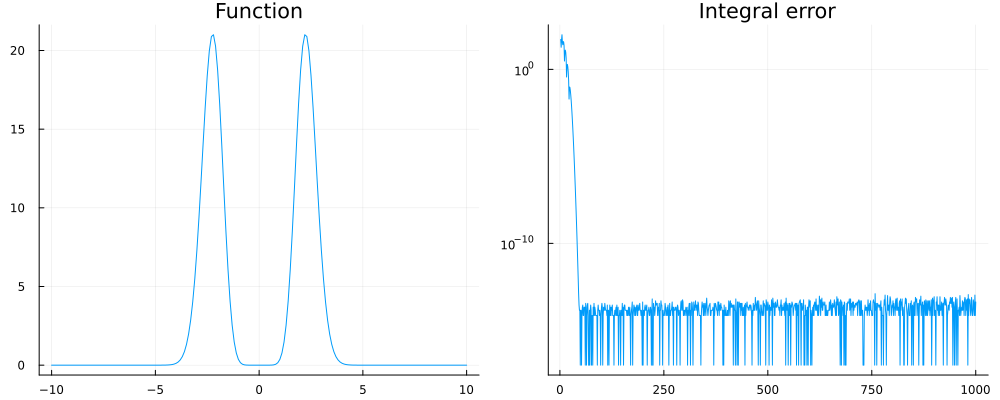

In [25]:
int_err_plot(Trap,f,true_res,s)

## Clenshaw-Curtis
In order to get to the Clenshaw-Curtis quadrature method, we change variables $x=\cos(θ)$:
$$
I = \int_{-1}^{1}f(x)\mathrm{d}x = \int_0^π f(\cos(θ))\sin(θ)\mathrm{d}θ.
$$
We can now use the cosine series of $f(\cos(θ))$, with coefficients $a_i,~i\in\mathbb{N}$. We then get that the integral becomes
$$
I≈a_0+\sum_{k=1}^\infty\frac{2a_{2k}}{1-(2k)^2}, \text{ with }a_k=\frac{2}{π}\int_0^π f(\cos(θ))\cos(kθ)\mathrm{d}θ.
$$
You can use a FFT to get the coefficients.

Convergence order: ???

Pros: High accuracy, Suitable for Oscillations (ish), fast-ish.

Cons: Bad with singularities, discontinuities.


In [26]:
function Clen_Curt(f,s)

    N = s.N 
    
    if mod(N,2) != 0
       N -= 1 
    end
    
    f_int = stand_int(f,s)
    n = 0:N/2;
    D = 2 * cos.(2* transpose(n) .* n * pi/N)/N;
    D[1,:] = D[1,:] .* 0.5;
    d = [1; 2 ./ (1 .- (2:2:N).^2)];
    w = D * d;
    x = cos.( (0:N) * π / N );
    w = [w;w[length(w)-1:-1:1]];
    res = sum(map(f_int,x) .* w)
    
    return res
end

Clen_Curt (generic function with 1 method)

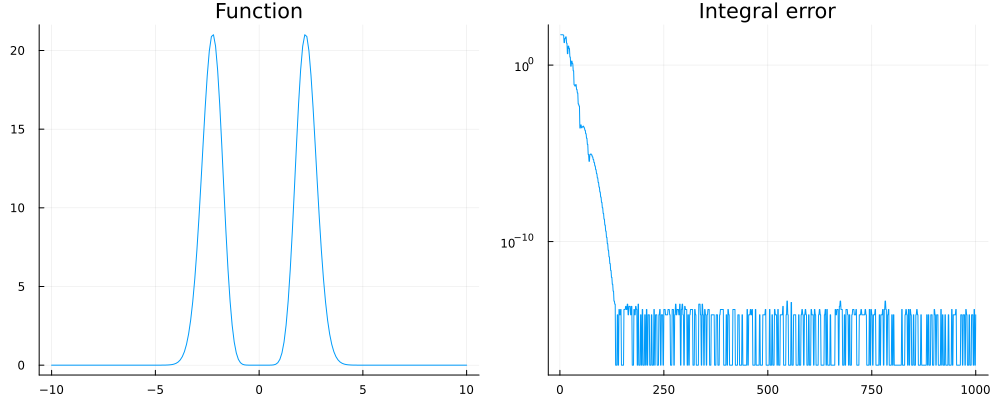

In [27]:
int_err_plot(Clen_Curt,f,true_res,s)

## Modified Filon-Clenshaw-Curtis
Say we want to approximate
$$
\int_0^L f(x)\mathrm{d}x,
$$
where $f$ has a singularity at 0. Subdivide the grid into $M$ intervals bounded by:
$$
x_i = L\left(\frac{i}{M}\right)^q, ~~~ i = 1,\dots,M.
$$
Over interval $[x_i,x_{i+1}], i=1,\dots,M-1$, we use Clenshaw-Curtis. Note that we skip the singularity a tiny bit.

Pros: Deals with Clenshaw Curtis at singularities, so those pros

Cons: There are a lot of variables involved, problematic with oscillations?

In [28]:
function m_Filon_Clen_Curt(f_o,s)

    N = s.N;
    M = s.M;
    q = s.q;

    if mod(N,2) != 0
       N -= 1 
    end
    
    f = x-> map(f_o,map(s.c,x))  .* map(s.w,x); # map to real line

    mua = s.a * ((1:M) ./ M).^q;
    mub = s.b * ((1:M) ./ M).^q;
    
    resa = 0;
    resb = 0;

    for i1 = 1:(M-1)
        sa = curv(x->x,mua[i1],mua[i1+1],x->1,N,M,q)
        sb = curv(x->x,mub[i1],mub[i1+1],x->1,N,M,q)
        resa = resa + Clen_Curt(f,sa);
        resb = resb + Clen_Curt(f,sb);
    end

    if s.a == 0
        resa = 0;
    end
    if s.b == 0
        resb = 0;
    end
    
    res = resb-resa;
    
    return res

end

m_Filon_Clen_Curt (generic function with 2 methods)

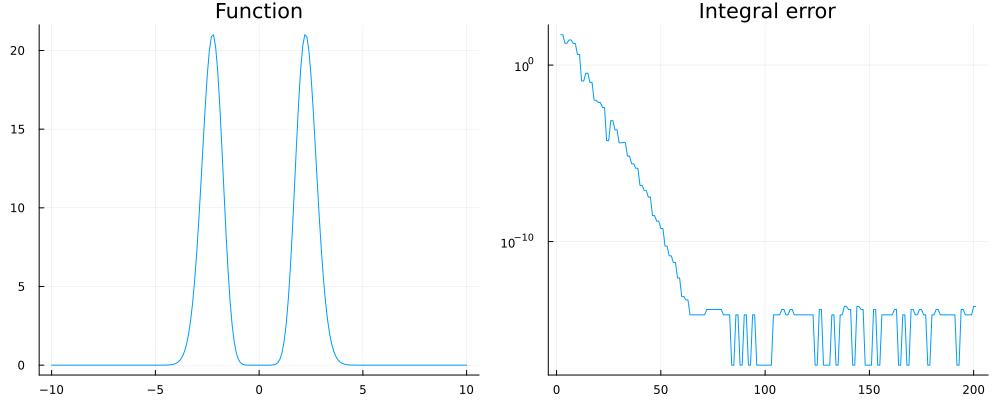

In [29]:
s = curv(x -> x, -10,10,x->1,10,40,210)
int_err_plot(m_Filon_Clen_Curt,f,true_res,s,200)